In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Lambda, Input, AveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras import backend as K
import tensorflow as tf 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import random
#import cv2
import os

C:\Users\gabri\anaconda3\envs\mlenv\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\gabri\anaconda3\envs\mlenv\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\gabri\anaconda3\envs\mlenv\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\gabri\anaconda3\envs\mlenv\lib\site-package

In [2]:
# Check filenames 
image_names=list(os.listdir("./Resources/images/Classes"))
image_names.sort()
print(image_names)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Covid', 'Edema', 'Enlarged_Cardiomediastinum', 'Fracture', 'Lung_Lesion', 'Lung_Opacity', 'No_Finding', 'Pleural_Other', 'Pneumonia', 'Pneumothorax', 'Support_Devices']


In [3]:
# Directory with Atelectasis
atele_dir=os.path.join("./Resources/images/Classes/Atelectasis")
df =pd.DataFrame.from_records({"file_name":os.listdir(atele_dir),"condition": "Atelectasis"})
for f in image_names[2:]:
    folder_path="./Resources/images/Classes/" + f
    temp_df= pd.DataFrame.from_records({"file_name":os.listdir(folder_path),"condition": f })
    df=df.append(temp_df)
    
df["condition"].value_counts()

No_Finding                    1898
Covid                          184
Pneumothorax                   164
Lung_Opacity                   156
Edema                          155
Support_Devices                154
Consolidation                  145
Enlarged_Cardiomediastinum     143
Atelectasis                    143
Fracture                       142
Lung_Lesion                    127
Pneumonia                      118
Pleural_Other                   99
Name: condition, dtype: int64

In [4]:
df.to_csv("Labels.csv")

In [5]:
# balance classes - random Random Sampling No_Finding
df_no_finding = df[df["condition"]=="No_Finding"].sample(n=150, random_state=42)
df_balanced = df[df["condition"]!="No_Finding"].append(df_no_finding)
df_balanced["condition"].value_counts()

Covid                         184
Pneumothorax                  164
Lung_Opacity                  156
Edema                         155
Support_Devices               154
No_Finding                    150
Consolidation                 145
Enlarged_Cardiomediastinum    143
Atelectasis                   143
Fracture                      142
Lung_Lesion                   127
Pneumonia                     118
Pleural_Other                  99
Name: condition, dtype: int64

In [6]:
df_balanced["file_name"] = "./Resources/images/Classes/"+df_balanced["file_name"]

In [7]:
batch_size = 32
img_height = 180
img_width = 180
data_dir = "./Resources/images/Classes/"

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3764 files belonging to 14 classes.
Using 3012 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3764 files belonging to 14 classes.
Using 752 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)
class_number = len(class_names)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Covid', 'Edema', 'Enlarged_Cardiomediastinum', 'Fracture', 'Lung_Lesion', 'Lung_Opacity', 'No_Finding', 'Pleural_Other', 'Pneumonia', 'Pneumothorax', 'Support_Devices']


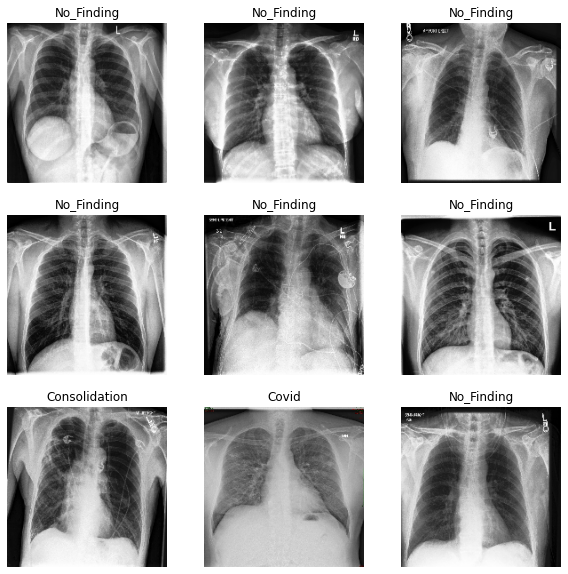

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
num_classes = class_number

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [14]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [15]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
95/95 [==============================] - 51s 535ms/step - loss: 1.9534 - accuracy: 0.5003 - val_loss: 1.9019 - val_accuracy: 0.5133
Epoch 2/3
95/95 [==============================] - 47s 490ms/step - loss: 1.7907 - accuracy: 0.5229 - val_loss: 1.8050 - val_accuracy: 0.5519
Epoch 3/3
95/95 [==============================] - 43s 453ms/step - loss: 1.6797 - accuracy: 0.5422 - val_loss: 1.7565 - val_accuracy: 0.5519


In [16]:
VGG16_model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(180, 180, 3))),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [17]:
VGG16_model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [18]:
VGG16_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
95/95 [==============================] - 957s 10s/step - loss: 2.8222 - accuracy: 0.4851 - val_loss: 1.9518 - val_accuracy: 0.5133
Epoch 2/3
95/95 [==============================] - 965s 10s/step - loss: 1.9819 - accuracy: 0.5020 - val_loss: 1.9742 - val_accuracy: 0.5133
Epoch 3/3
95/95 [==============================] - 993s 10s/step - loss: 1.9881 - accuracy: 0.5020 - val_loss: 1.9486 - val_accuracy: 0.5133


In [19]:
VGG16_model.save("VGG16_model.h5")